In [21]:
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [22]:
##########################################
##########HYPERPARAMS#####################
epochs = 5
learning_rate = 1e-3
weight_decay = 0.9
batch_size = 128
seq_length = 8
log_interval = 1 #Log/show loss per batch
##########################################
##########################################

# Load MIDI files from npz

In [23]:
data = np.load('../YamahaPianoCompetition2002NoTranspose.npz')

midiDatasetTrain = data['train']
midiDatasetTest = data['test']

data.close()

"""
print("Training set: ({}, {}, {}, {})".format(midiDatasetTrain.size()[0],
                                                midiDatasetTrain.size()[1],
                                                midiDatasetTrain.size()[2],
                                                midiDatasetTrain.size()[3]))
print("Test set: ({}, {}, {}, {})".format(midiDatasetTest.size()[0],
                                                midiDatasetTest.size()[1],
                                                midiDatasetTest.size()[2],
                                                midiDatasetTest.size()[3]))
"""

print("Training set: {}".format(midiDatasetTrain.shape))
print("Test set: {}".format(midiDatasetTest.shape))

Training set: (39782, 1, 96, 60)
Test set: (9691, 1, 96, 60)


In [24]:
fullPitch = 128
_, _, length, reducedPitch = midiDatasetTrain.shape

# Load Autoencoder

In [25]:
from utils.VAE_Sigmoid import VAE
from utils.VAE_ReLU import VAE_ReLU
from loadModel import loadModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###VARIATIONAL CONV AUTOENCODER Sigmoid############
#autoencoderModel = VAE()
#pathToModel = '../models/YamahaPC2002_VAE_Reconstruct_NoTW_12Epochs_SigmoidEmbed100.model'
###########################################

###VARIATIONAL CONV AUTOENCODER Sigmoid############
autoencoderModel = VAE_ReLU()
pathToModel = '../models/YamahaPC2002_VAE_Reconstruct_NoTW_10Epochs_ReLU.model'
###########################################

autoencoderModel = loadModel(autoencoderModel, pathToModel, dataParallelModel=False)


--------GPU model restored--------



# CDVAE

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
midiDatasetTrain = torch.from_numpy(midiDatasetTrain)
trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=False, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=False, drop_last=True)

In [28]:
class LSTM(nn.Module):
    def __init__(self, batch_size=7, lstm_layers=2, hidden_size=400, seq_length=7):
        super(LSTM, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.seq_length = seq_length

        ###LSTMCells######
        self.lstmC1 = nn.LSTMCell(input_size=100, hidden_size=self.hidden_size, bias=True)
        self.drop1 = nn.Dropout(p=0.2)
        self.lstmC2 = nn.LSTMCell(input_size=400, hidden_size=self.hidden_size, bias=True)
        self.drop2 = nn.Dropout(p=0.2)
        self.lstmC3 = nn.LSTMCell(input_size=400, hidden_size=self.hidden_size, bias=True)
        #################
        
        self.fc = nn.Linear(self.hidden_size,100)
    
    def hiddenInitLSTM(self,embed):
        hiddenState = torch.zeros(self.lstm_layers,embed.size()[0], self.hidden_size).double().to(device)
        cellState = torch.zeros(self.lstm_layers,embed.size()[0], self.hidden_size).double().to(device)
        return hiddenState,cellState
    
    def hiddenInitLSTMCell(self):
        hiddenState = torch.zeros(int(self.batch_size/self.seq_length),
                                    self.hidden_size, dtype=torch.double).to(device)
        cellState = torch.zeros(int(self.batch_size/self.seq_length),
                                    self.hidden_size, dtype=torch.double).to(device)
        hS2 = torch.zeros(int(self.batch_size/self.seq_length),
                              self.hidden_size, dtype=torch.double).to(device)
        cS2 = torch.zeros(int(self.batch_size/self.seq_length),
                              self.hidden_size, dtype=torch.double).to(device)
        
        return (hiddenState, cellState), (hS2, cS2)

    def forward(self, embed, future = 0):#, lenghts):
        
        (h_t, c_t),(h2_t, c2_t) = self.hiddenInitLSTMCell()

        embedChunks = torch.chunk(embed, self.seq_length, dim=0)
        
        outputs = []
        for i, input_t in enumerate(embedChunks):
            h_t, c_t = self.lstmC1(input_t,(h_t, c_t))
            h2_t, c2_t = self.lstmC2(h_t,(h2_t, c2_t))
            output = self.fc(h2_t)
            outputs += [output]
        
        for i in range(future):
            h_t, c_t = self.lstmC1(output,(h_t, c_t))
            h2_t, c2_t = self.lstmC2(h_t, (h2_t, c2_t))
            output = self.fc(h2_t)
            outputs += [output]
            
        lstmOut = torch.stack(outputs, 1)
        embedChunks = torch.stack(embedChunks,1)

        if(self.training):
            print('embedding');print(embedChunks[0,6,:3])
            print('lstmOut');print(lstmOut[0,7,:3])
        
        if(embed.size()[0]==self.seq_length):
            embed = embed.squeeze(1)

        return embedChunks, lstmOut

    

model = LSTM(batch_size=batch_size, seq_length=seq_length).double().to(device)

#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-1)
optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

def loss_function(embed, lstmOut):
    
    batch_sizeMin1 = embed.size()[0]-1
    MSELoss = nn.MSELoss(reduction='elementwise_mean')
    #BATCHSIZE 7
    if(embed.size()[0]==model.seq_length):
        print("loss");print(embed.size());print(lstmOut.size())
        lstmOut = torch.squeeze(lstmOut,1)
        mseLSTM = MSELoss(lstmOut[:-1,:],embed[1:,:])
        totalLoss =  mseLSTM / (embed.size()[1]*batch_sizeMin1)

    #BATCHSIZE > 7
    else:
        #print("LOSS");print(embed.size());print(lstmOut.size())
        mseLSTM = MSELoss(lstmOut[:,:-1,:],embed[:,1:,:])
        totalLoss = mseLSTM# / (embed.size()[0]*(embed.size()[1]-1)*embed.size()[2])
        
    return totalLoss

def train(epoch):
    model.train()
    trainLoss = 0

    for batch_idx, data in enumerate(trainLoader):
        #print(batch_idx)
        data = data.float().to(device)
        optimizer.zero_grad()
        embedding, _ = autoencoderModel.encoder(data)
        embedding = embedding.double()
        embedding, lstmOut = model(embedding, future = 0)
        
        loss = loss_function(embedding, lstmOut)
        
        ###LSTMCell###########
        #reconPrediction = autoencoderModel.decoder(lstmOut)
        ######################

        loss.backward()
        trainLoss += loss.item()
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                loss.item() / (len(data)-(model.batch_size/7))))
        #if(batch_idx==1):
        #   break
    print('====> Epoch: {} Average Loss: {:.4f}'.format(
          epoch, trainLoss / (len(trainLoader.dataset)-batch_idx*(model.batch_size/model.seq_length))))

def test(epoch):
    model.eval()
    testLoss = 0
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            data = data.float().to(device)
            embedding, logvar = autoencoderModel.encoder(data)
            embedding = embedding.double()
            embedding, lstmOut = model(embedding)
            ###LSTMCell#####
            #reconPrediction = autoencoderModel.decoder(lstmOut)
            ################
            testLoss += loss_function(embedding, lstmOut).item()
            
            #if(i==1):
            #    break
    testLoss /= (len(testLoader.dataset)-i*(model.batch_size/model.seq_length))

    print('====> Test set Loss: {:.4f}'.format(testLoss))

In [29]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

embedding
tensor([0.0000, 0.0000, 1.4341], dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([0.0013, 0.0277, 0.0041], dtype=torch.float64, grad_fn=<SliceBackward>)
Train Epoch: 1 [0/39782 (0%)]	Loss: 702.576203
embedding
tensor([0., 0., 0.], dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([-1.0583,  1.9852,  2.0511], dtype=torch.float64, grad_fn=<SliceBackward>)
Train Epoch: 1 [128/39782 (0%)]	Loss: 532.128541
embedding
tensor([0.0000, 1.4578, 0.0000], dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([ 1.1504, -0.1601,  2.3972], dtype=torch.float64, grad_fn=<SliceBackward>)
Train Epoch: 1 [256/39782 (1%)]	Loss: 629.963172
embedding
tensor([0.0000, 5.0382, 0.0000], dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([-0.6510,  1.0338,  1.0854], dtype=torch.float64, grad_fn=<SliceBackward>)


KeyboardInterrupt: 

# LOAD LSTM

In [31]:
pathToModel = '../models/LSTM_YamahaPianoComp2002Big_1Epoch_ReLUTEST.model'
###########################################

model = loadModel(model, pathToModel, dataParallelModel=False)


--------GPU model restored--------



In [32]:
#torch.save(model,'/media/EXTHD/niciData/models/YamahaPianoComp2002_5Epochs_LSTM_noTW.model')

In [33]:
np.set_printoptions(precision=2, suppress=True, threshold=np.inf)


(9, 1, 96, 60)
INPUT
(768, 128)


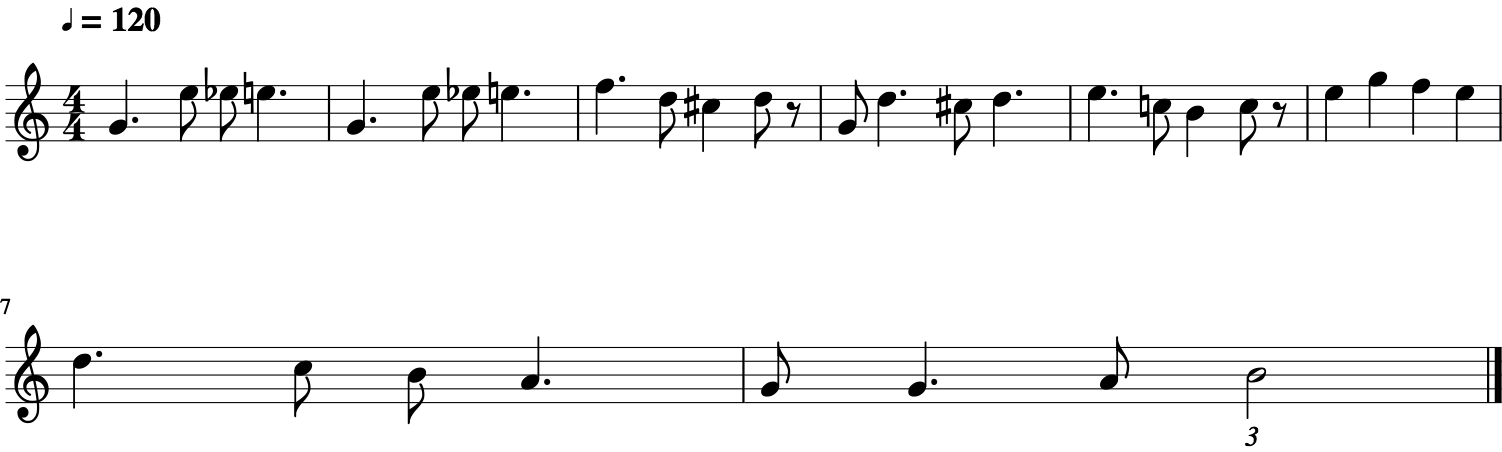

PREDICTION


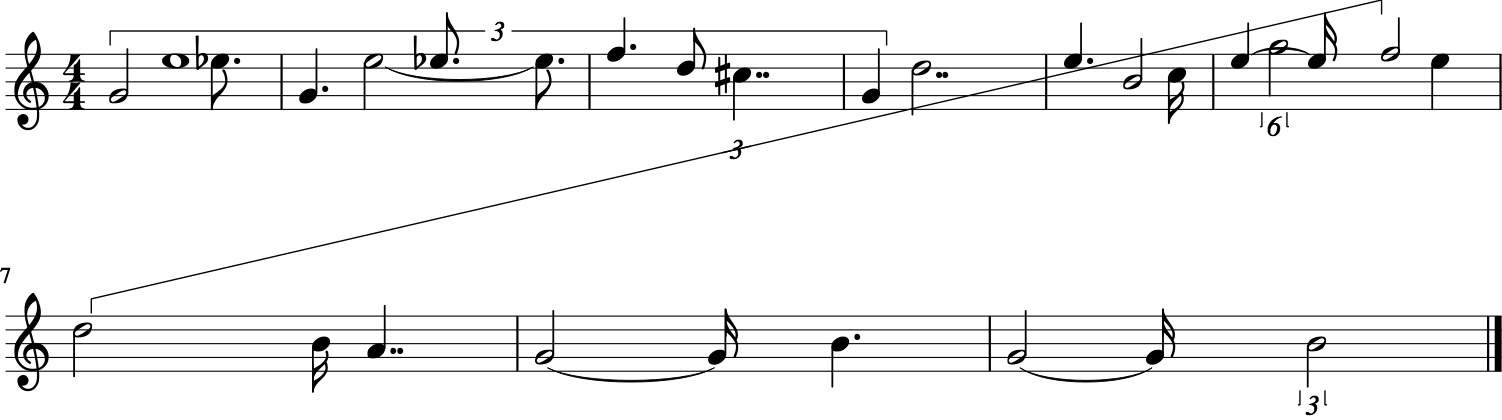




(9, 1, 96, 60)
INPUT
(768, 128)


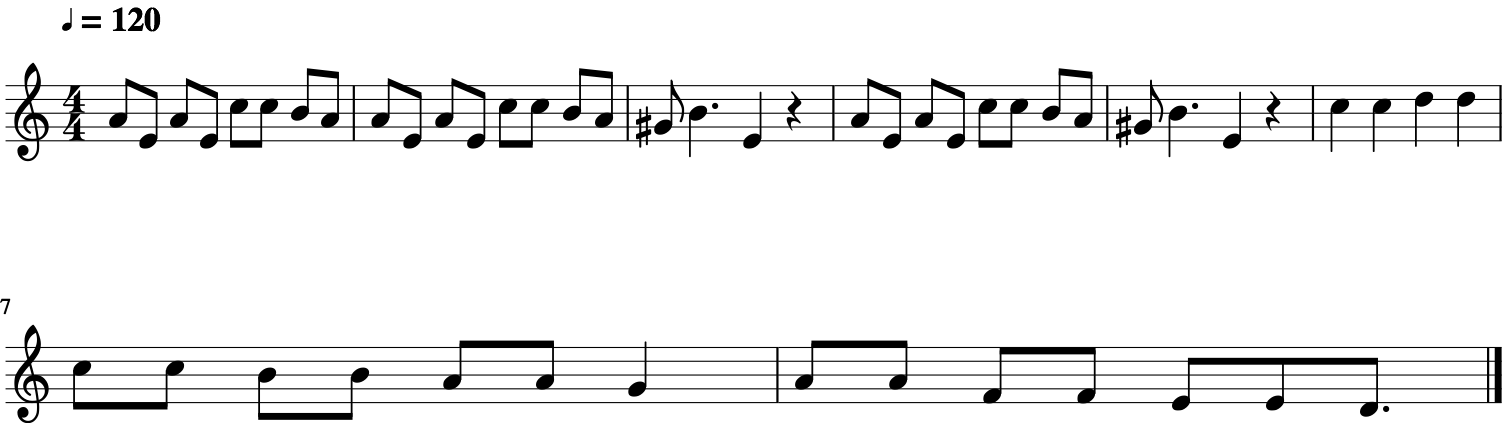

PREDICTION


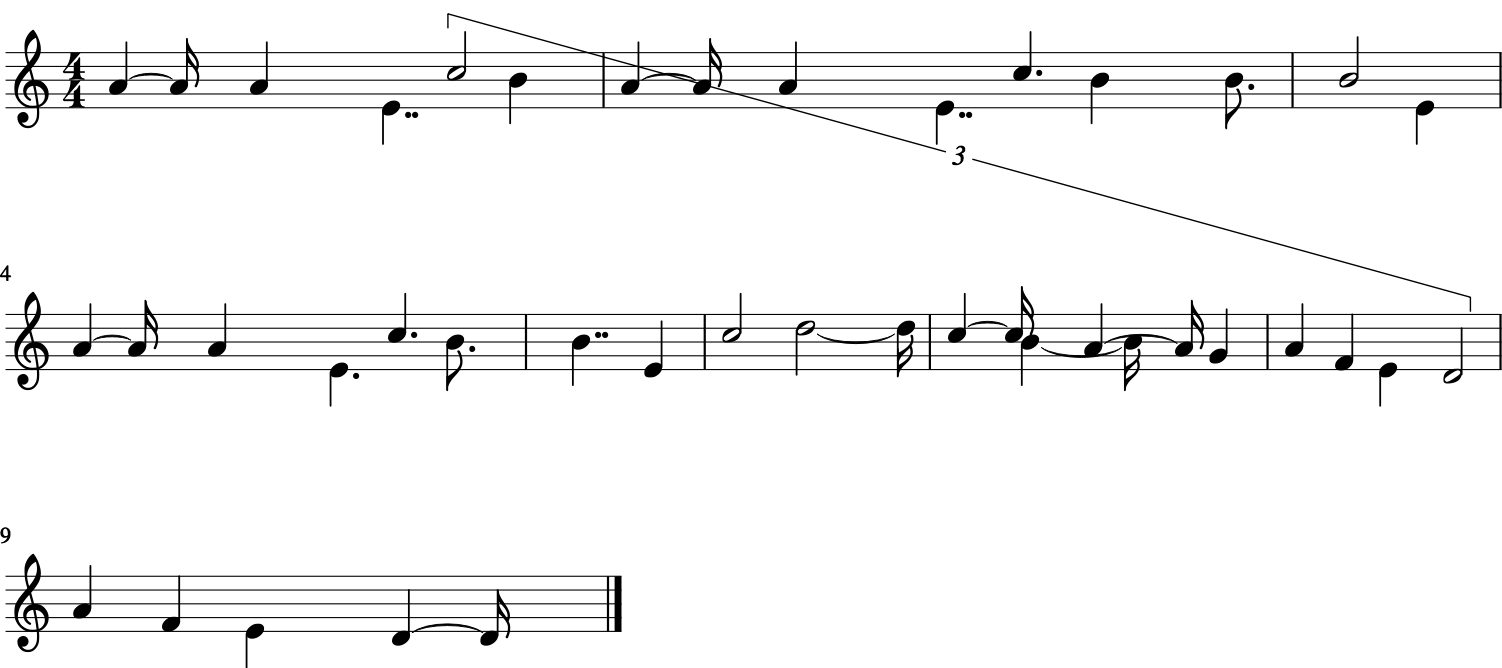




(9, 1, 96, 60)
INPUT
(768, 128)


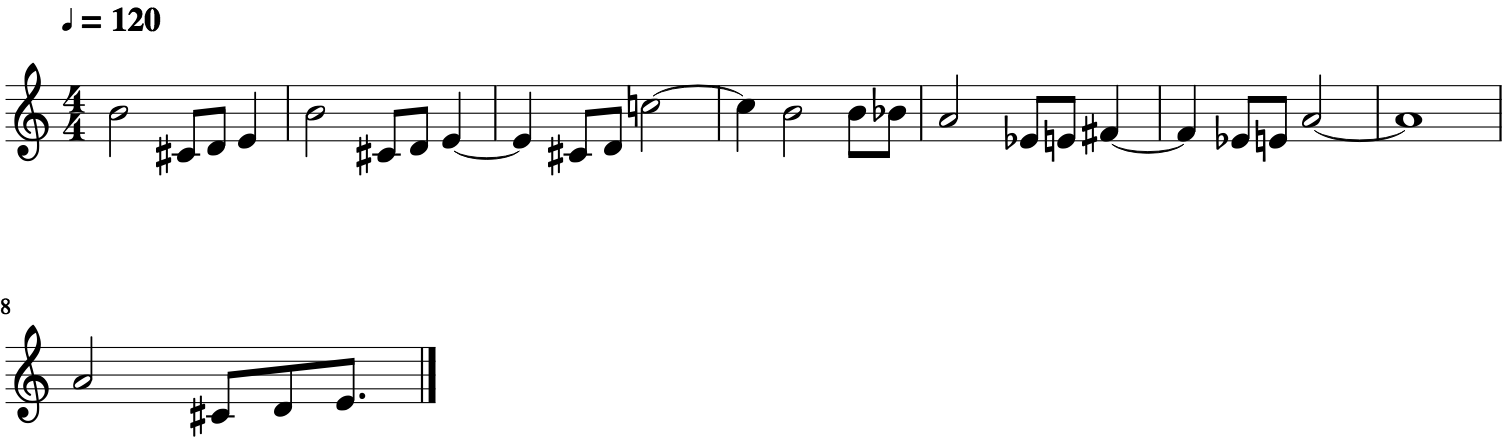

PREDICTION


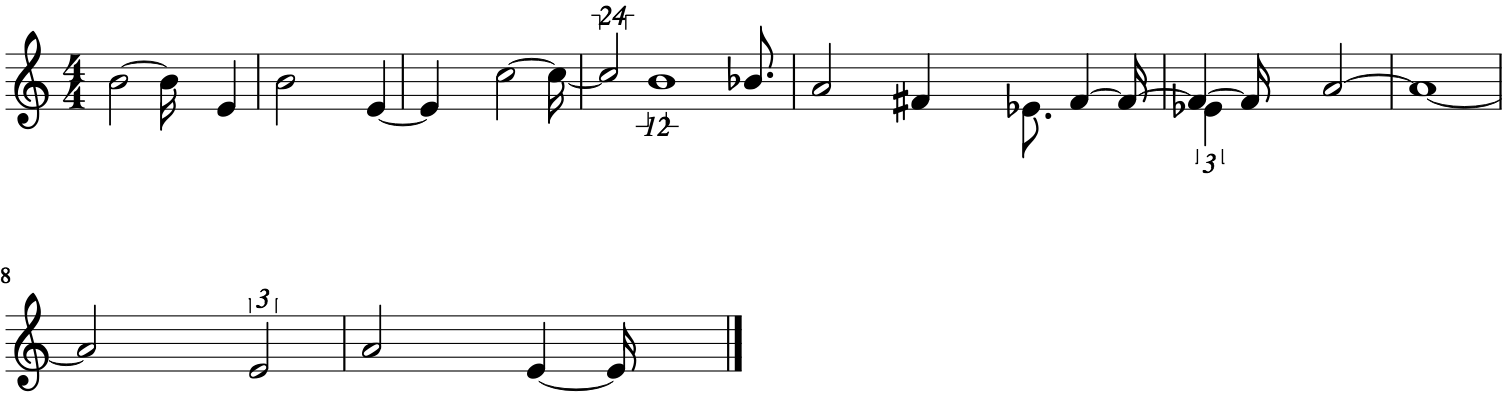




(9, 1, 96, 60)
INPUT
(768, 128)


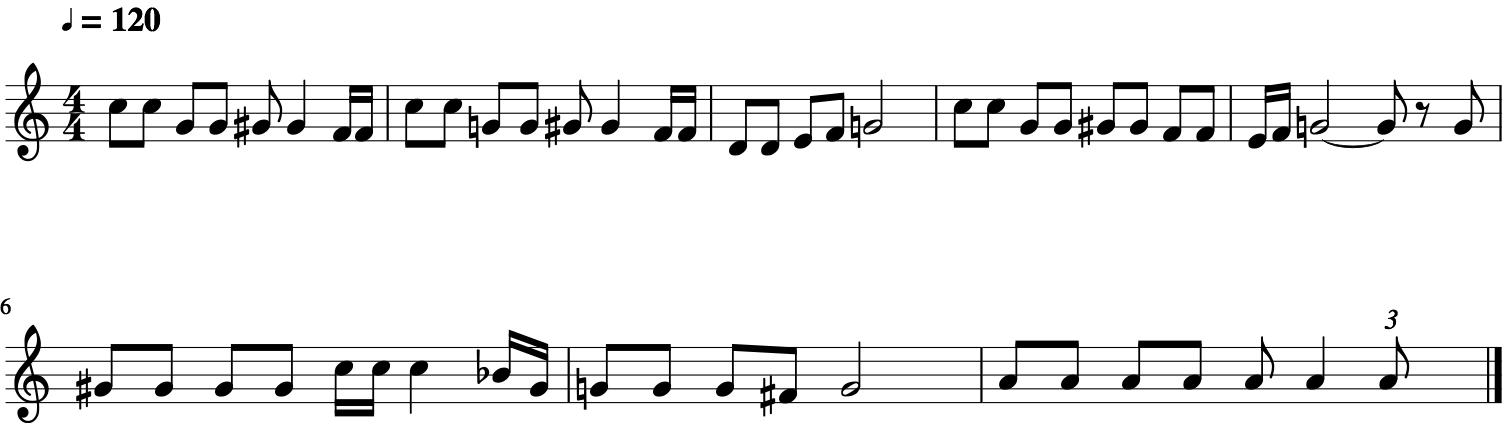

PREDICTION


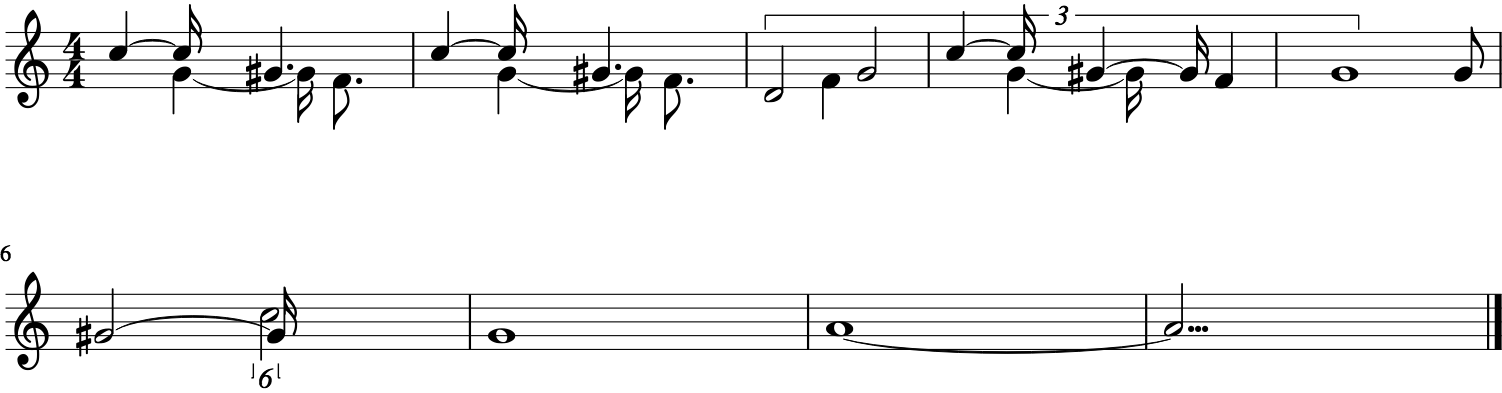




(9, 1, 96, 60)
INPUT
(768, 128)


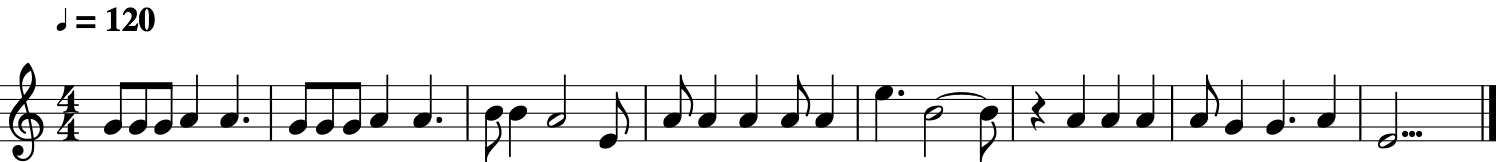

PREDICTION


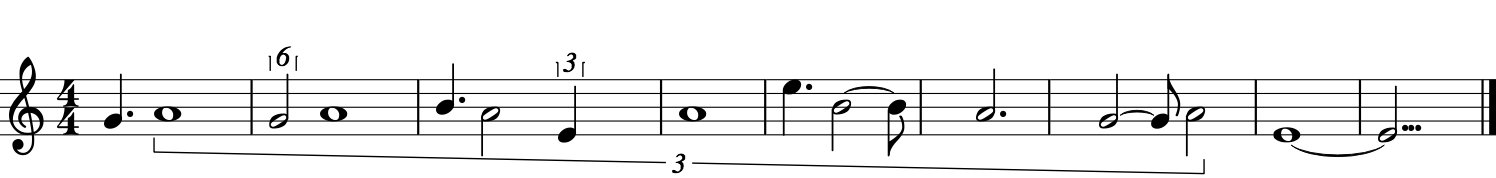




(9, 1, 96, 60)
INPUT
(768, 128)


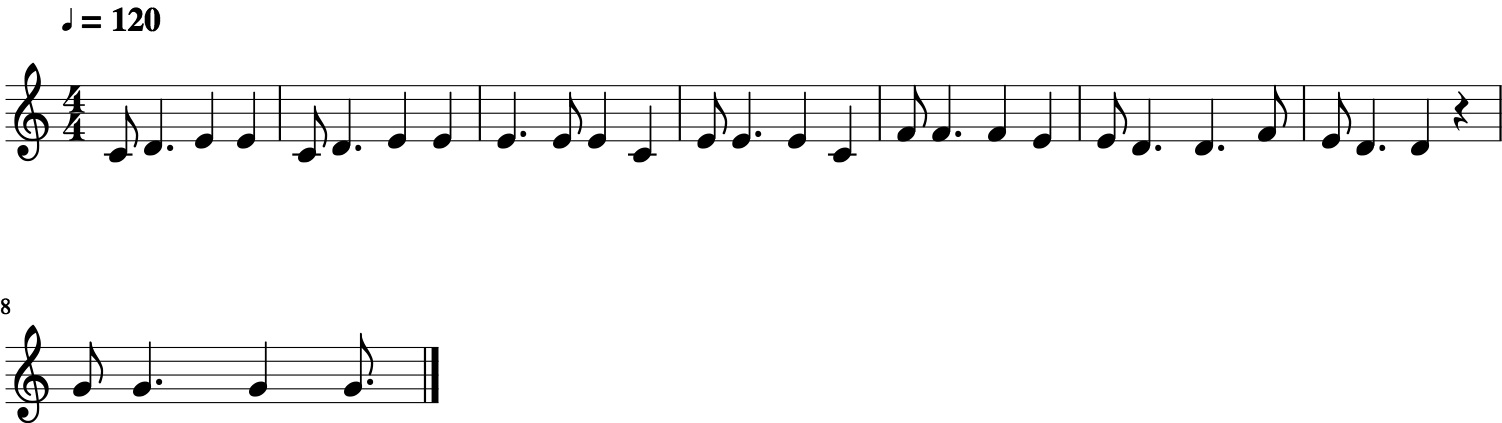

PREDICTION


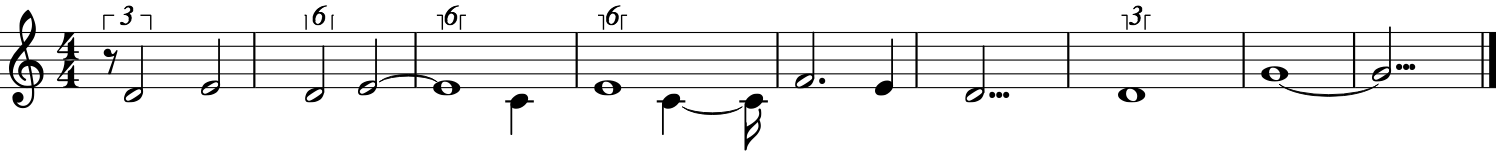




(9, 1, 96, 60)
INPUT
(768, 128)


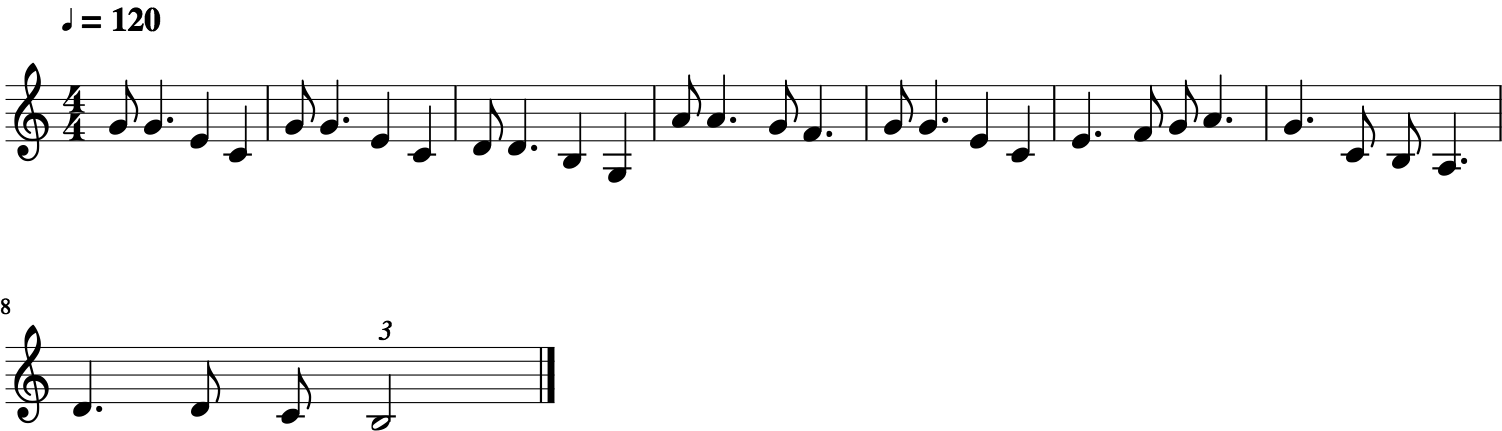

PREDICTION


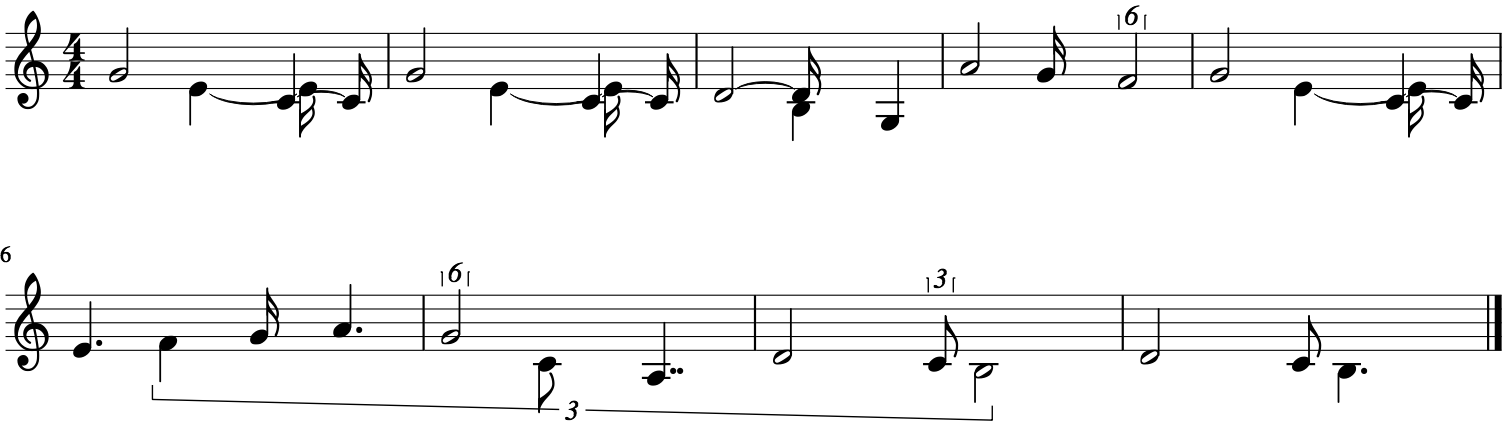




(9, 1, 96, 60)
INPUT
(768, 128)


SubConverterFileIOException: png file of xml not found. Or file >999 pages?

In [36]:
playSeq = 0
model.batch_size=8

if(model.train()):
    model.eval()
if(autoencoderModel.train()):
    autoencoderModel.eval()

pathToSampleSeq = "../WikifoniaDatabase/test/Hilsen-til-forarssolen---Det-er-foraar-alting-klippes-ned.mid"
###PREDICT 8th SEQUENCE
for pathToSampleSeq in glob.glob('../WikifoniaDatabase/test/*.mid'):
    with torch.no_grad():

        sampleNp1 = getSlicedPianorollMatrixNp(pathToSampleSeq)
        sampleNp1 = deleteZeroMatrices(sampleNp1)
        sample = np.expand_dims(sampleNp1[0,:,36:-32],axis=0)
        #print(sample.shape)
        for i, sampleNp in enumerate(sampleNp1[playSeq:playSeq+(seq_length-1)]):
            #print(sampleNp.shape)
            if(np.any(sampleNp)):
                sampleNp = sampleNp[:,36:-32]
                sampleNp = np.expand_dims(sampleNp,axis=0)
                sample = np.concatenate((sample,sampleNp),axis=0)
        samplePlay = sample[0,:,:]
        for s in sample[1:]:
            samplePlay = np.concatenate((samplePlay,s),axis=0)
        samplePlay = addCuttedOctaves(samplePlay)
        #print(samplePlay.shape)
        #####PREPARE SAMPLE
        sample = torch.from_numpy(sample).float().to(device)
        sample = torch.unsqueeze(sample,1)
        #print(sample.size())

        #####MODEL##############
        #print("MODEL")
        embed,logvar = autoencoderModel.encoder(sample)
        #print(embed.size())
        embed = embed.double()
        #embed = model.splitEmbedding(embed)
        embed, lstmOut = model(embed, future=1)
        #print(lstmOut[:,:,:].squeeze(0).size())
        #print(lstmOut.size())
        lstmOut = lstmOut.float()
        #pred = autoencoderModel.decoder(lstmOut[0,-1:,:])
        pred = autoencoderModel.decoder(lstmOut[0,:,:].squeeze(1))
        ########################

        prediction = pred.squeeze(0).squeeze(0).cpu().numpy()
        print(prediction.shape)
        predict = np.squeeze(prediction, axis=1)
        #print(predict.shape)

        #####PLAY WHOLE LSTM OUT#############
        prediction = predict[0,:,:]
        for pred in predict[1:]:
            prediction = np.concatenate((prediction, pred), axis =0)
        #####################################

        #NORMALIZE PREDICTIONS
        #reconstruction /= np.abs(np.max(reconstruction))
        prediction /= np.abs(np.max(prediction))
        #print(prediction)

        #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
        #reconstruction[reconstruction < 0.3] = 0
        prediction[prediction < 0.3] = 0
        #print(prediction)

        samplePlay = debinarizeMidi(samplePlay, prediction=False)
        samplePlay = addCuttedOctaves(samplePlay)
        #reconstruction = debinarizeMidi(reconstruction, prediction=True)
        #reconstruction = addCuttedOctaves(reconstruction)
        prediction = debinarizeMidi(prediction, prediction=True)
        prediction = addCuttedOctaves(prediction)
        print("INPUT")
        print(samplePlay.shape)
        pianorollMatrixToTempMidi(samplePlay, show=True,showPlayer=True,autoplay=False)
        #print("RECONSTRUCTION")
        #pianorollMatrixToTempMidi(reconstruction, show=True,
        #                            showPlayer=True,autoplay=True, prediction=True)
        print("PREDICTION")
        pianorollMatrixToTempMidi(prediction, prediction=True, 
                                  show=True,showPlayer=True,autoplay=False)        
        print("\n\n")


print('')